In [1]:
from processing.polyphony import *
import processing.polyphony as pp 


In [2]:
#output_sequence_len = 0 if not encoder_decoder else >=1

# Data INFO
# ~175K midi files  
# Files could be short melodies, loop compositions or long symphonies or songs
# ~10K midi files in each of the 16 top level subdirectories 
# Considering 300 midi files at present, at 8 resolution..~ 0.2% Dataset
# Generating a polyphonic monophony music (multiple instruments each following a monophonic melody line independently) or type of contrapuntal 
train_source, val_source, test_source  = sample_dataset('./lpd_5/all', nsamples=10, train_size=0.9, val_size=0.2, input_sequence_len=100, output_sequence_len=100, resolution=8, batch_size=128, encoder_decoder=True)

Preparing test dataset...: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


In [3]:
train_source = ('lpd_5_batched/train_inputs', 'lpd_5_batched/train_outputs')
music_loader = load_music_batches(*train_source, encoder_decoder=True)
steps = len(os.listdir(train_source[0]))-1
steps


14

In [4]:
val_source = ('lpd_5_batched/val_inputs', 'lpd_5_batched/val_outputs')
val_music_loader = load_music_batches(*val_source, encoder_decoder=True)
val_steps = len(os.listdir(val_source[0]))-1
val_steps

0

In [5]:
from models import transformer_encoder_decoder
model = transformer_encoder_decoder(music_dim=pp.vocab['last']+1)
model.summary()

Using TensorFlow backend


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, None, 100)            42100     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, None, 100)            42100     ['input_2[0][0]']         

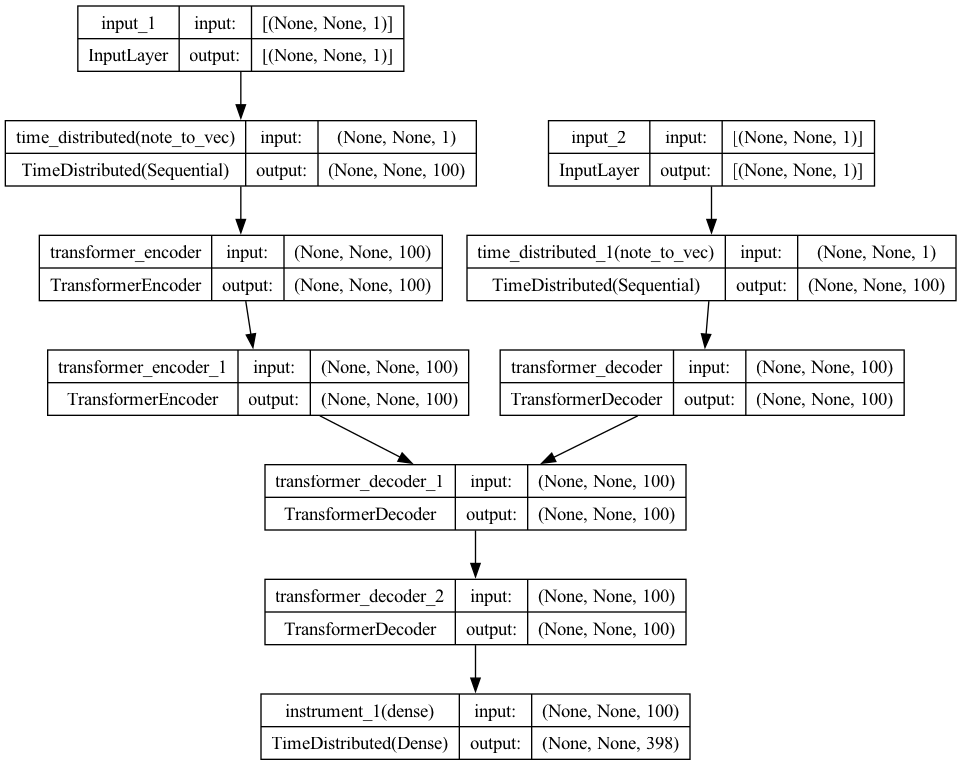

In [6]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [7]:
import tensorflow as tf
import os


class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, model, checkpoint_dir, save_best_only=True):
        super(ModelCheckpoint, self).__init__()
        self.model = model
        self.checkpoint_dir = checkpoint_dir
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if self.save_best_only and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            filepath = os.path.join(self.checkpoint_dir, f"best_model.keras")
            self.model.save(filepath, overwrite=True)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")
        else:
            filepath = os.path.join(self.checkpoint_dir, f"model_epoch_{epoch}.keras")
            self.model.save(filepath, overwrite=True)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")

modelname = "encoder-decoder-transformer-10Ksamples-1instrument-longer-2"
checkpoint_dir = f"./{modelname}-checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = ModelCheckpoint(model, checkpoint_dir)
callbacks_list = [model_checkpoint]   



In [9]:
history = model.fit(music_loader, steps_per_epoch=steps, validation_data=val_music_loader, validation_steps=val_steps, epochs=50, callbacks=callbacks_list)

Epoch 1/50
 1936/13230 [===>..........................] - ETA: 1:20:42 - loss: 4.3503 - accuracy: 0.3463

KeyboardInterrupt: 

In [12]:
model.save(modelname)

INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer-2/assets


INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer-2/assets


In [7]:
model = tf.keras.models.load_model(modelname)

In [6]:
tracks = sample_track('lpd_5/all', nsamples=100, input_sequence_len=100, resolution=8)

Sampling tracks...: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


In [9]:
x, y = tracks[randint(0, len(tracks)-1)]
composer = compose_music(music_model=model, cue=x, topn=129, encoder_decoder=True, print_gen=True, )
x.shape, y.shape

((100, 1), (919, 1))

In [10]:
total_track_length = y.shape[0]
composition_length = int(0.5*total_track_length)
TEMPO = 60

print(f"Composing for {composition_length} time steps at {TEMPO} bpm")
for _ in range(composition_length):
    composition = next(composer)
    print(composition[-1])
  


output_midi_path = f'generated_track_transformer.mid'
output_audio_path = f'generated_track_transformer.wav'

print("Composition Done...")
generated_track = make_midi(composition, tempo=TEMPO)
print("Track Done...")
print("Generated Midi file Done...")

midi_to_wav(output_midi_path, output_audio_path)
print("Generated Audio file Done...")



output_midi_path = 'original_track_transformer.mid'
output_audio_path = 'original_track_transformer.wav'

original_track = make_midi(composition=y[:composition_length], tempo=TEMPO)
print("Original Track Done...")
print("Original Midi file Done...")
midi_to_wav(output_midi_path, output_audio_path)
print("Original Audio file Done...")

Composing for 459 time steps at 60 bpm
Generation: 1
[248]
Generation: 2
[396]
Generation: 3
[387]
Generation: 4
[70]
Generation: 5
[99]
Generation: 6
[347]
Generation: 7
[322]
Generation: 8
[36]
Generation: 9
[340]
Generation: 10
[134]
Generation: 11
[24]
Generation: 12
[420]
Generation: 13
[347]
Generation: 14
[96]
Generation: 15
[200]
Generation: 16
[286]
Generation: 17
[49]
Generation: 18
[317]
Generation: 19
[39]
Generation: 20
[90]
Generation: 21
[36]
Generation: 22
[248]
Generation: 23
[135]
Generation: 24
[329]
Generation: 25
[264]
Generation: 26
[375]
Generation: 27
[267]
Generation: 28
[362]
Generation: 29
[357]
Generation: 30
[20]
Generation: 31
[376]
Generation: 32
[368]
Generation: 33
[158]
Generation: 34
[304]
Generation: 35
[55]
Generation: 36
[264]
Generation: 37
[191]
Generation: 38
[318]
Generation: 39
[332]
Generation: 40
[393]
Generation: 41
[163]
Generation: 42
[296]
Generation: 43
[110]
Generation: 44
[197]
Generation: 45
[229]
Generation: 46
[10]
Generation: 47
[